In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
import time
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator
plt.style.use('seaborn')
%matplotlib inline

In [2]:
df_geral = pd.read_csv('data/basegeral.csv', sep=';')

In [3]:
df_geral['Sexo'] = df_geral['Sexo'].str.upper()
df_geral.head()

,dt_notificacao,Sexo,raca,municipio,dt_primeiros_sintomas,sintomas,comorbidades,hospitalizacao,classe,Resultado,evolucao,dt_obito,cd_municipio,faixa_etaria,tipo
0,2020-04-23,FEMININO,NaN,RECIFE,2020-04-13,FEBRE DOR DE GARGANTA CEFALEIA PERDA DE OLFA...,NaN,NAO,EM INVESTIGACAO,AGUARDANDO RESULTADO,ISOLAMENTO DOMICILIAR,NaN,261160,20-29 anos,grave
1,2020-04-23,FEMININO,NaN,RECIFE,2020-04-14,TOSSE DOR NO CORPOASTENIA E ANOSMIA,NaN,NAO,EM INVESTIGACAO,AGUARDANDO RESULTADO,ISOLAMENTO DOMICILIAR,NaN,261160,40-49 anos,grave
2,2020-04-20,FEMININO,NaN,-,2020-03-06,DOR DE GARGANTA FEBRE,NaN,NaN,EM INVESTIGACAO,NaN,NaN,NaN,-,30-39 anos,leve
3,2020-04-23,FEMININO,NaN,RECIFE,2020-04-17,CEFALEIA MOLEZA OBSTRUCAO NASAL CORIZA,NaN,NAO,EM INVESTIGACAO,AGUARDANDO RESULTADO,ISOLAMENTO DOMICILIAR,NaN,261160,30-39 anos,grave
4,2020-04-23,FEMININO,NaN,-,2020-04-18,DOR DE GARGANTA OUTROS,NaN,NaN,EM INVESTIGACAO,NaN,NaN,NaN,-,60-69 anos,leve


In [4]:
grouped = df_geral.groupby('dt_notificacao')

In [5]:
lista_homem = []
lista_mulher = []
lista_indefinido = []
lista_data = []
for name, group in grouped:
    lista_mulher.append(len(group[group['Sexo']=="FEMININO"]))
    lista_homem.append(len(group[group['Sexo']=="MASCULINO"]))
    lista_indefinido.append(len(group[group['Sexo']=="INDEFINIDO"]))
    lista_data.append(name)

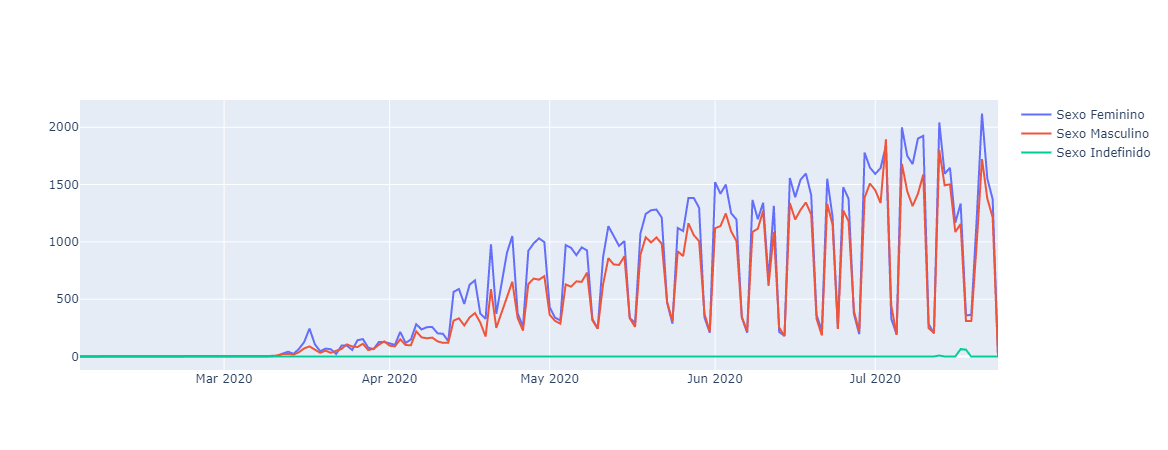

In [6]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=lista_data,
        y=lista_mulher,
        name="Sexo Feminino"
    ))

fig.add_trace(
    go.Scatter(
        x=lista_data,
        y=lista_homem,
        name="Sexo Masculino"
    ))
fig.add_trace(
    go.Scatter(
        x=lista_data,
        y=lista_indefinido,
        name="Sexo Indefinido"
    ))

fig.show()

### Análise do Gráfico

Como podemos ver a relação de casos entre homens e mulheres é muito parecida e sempre uma queda entre os picos. Essa queda sugere uma subnotificação em alguns dias da semana como já é sabido que ocorre. Mas podemos verificar isso com um simples experimento. 

O sexo indefinido foi excluído das análise por não apresentar números suficientes para análise.

### Verificação

No próximo experimento além de verificar se há ou não subnotificação vou fazer uma predição usanddo os dados da base que sintetiza os casos.

Outros agrupamentos podem ser realizados mas provavelmente terão o mesmo comportamento.

In [7]:
df_sintetico = pd.read_csv('data/COVID-19 em Dados.csv')

In [8]:
df_sintetico.head()

,dt_referencia,dt_atualizacao,confirmados,obitos,tx_obitos,recuperados,tx_recuperados,isolamento,tx_isolamento,enfermaria,tx_enfermaria,uti,tx_uti,testes_novos,testes_acumulados,tx_testes,leitos_uti,tx_oc_uti,leitos_enf,tc_oc_enf
0,2020-07-24,2020-07-25,86752,6299,0.073,62949,0.726,451,0.005,3715,0.043,354,0.004,4994.0,194835.0,20295.312500,837.0,0.74,987.0,0.55
1,2020-07-23,2020-07-24,85042,6237,0.073,61995,0.729,332,0.004,3869,0.045,362,0.004,5310.0,189841.0,19775.104167,837.0,0.73,987.0,0.54
2,2020-07-22,2020-07-23,83234,6211,0.075,60360,0.725,330,0.004,3819,0.046,348,0.004,5319.0,184531.0,19221.979167,837.0,0.73,957.0,0.55
3,2020-07-21,2020-07-22,81382,6152,0.076,60119,0.739,333,0.004,3879,0.048,348,0.004,2696.0,179212.0,18667.916667,837.0,0.73,957.0,0.55
4,2020-07-20,2020-07-21,80441,6089,0.076,58821,0.731,302,0.004,3909,0.049,337,0.004,1746.0,176516.0,18387.083333,827.0,0.76,957.0,0.54


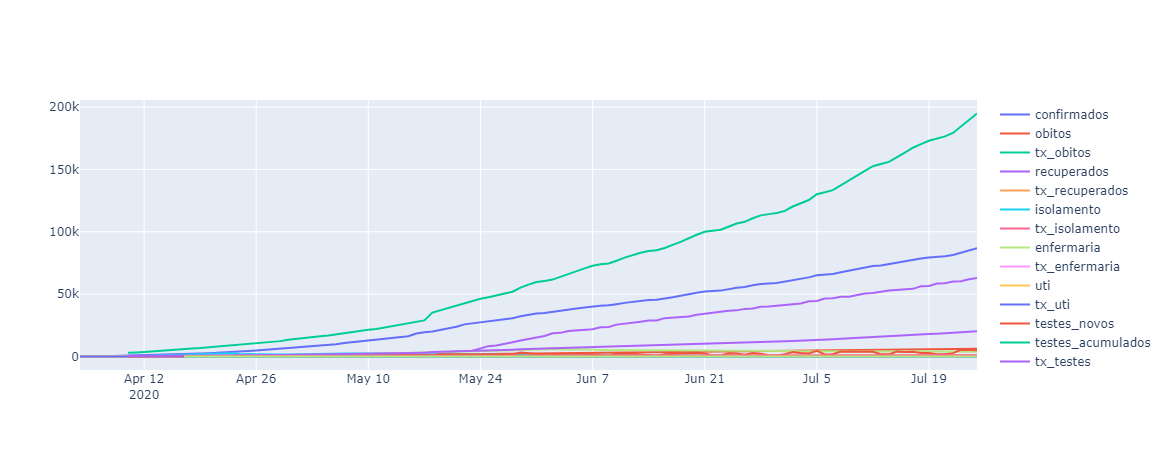

In [9]:
import plotly.graph_objects as go

fig = go.Figure()

for key in df_sintetico.keys()[2:]:
    fig.add_trace(
    go.Scatter(
        x=df_sintetico['dt_atualizacao'],
        y=df_sintetico[key],
        name=key
    ))

fig.show()

### Análise

Pelo comportamento das curvas é notório que todas elas estão em crescimento e seguem um comportamento parecido. É provável que todos as curvas acompanhem o comportamento da curva de casos confirmados já que intriscicamente dependem dela.

Exceto a taxa de testes pois seu comportamento depende mais de comportamentos governamentais.

Iremos assumir que isso é verdade para os próximos experimentos. 

Todos experimentos preditivos usarão o modelo do facebook (FbProphet) com taxa de confiança de 95%

In [10]:
df_sintetico2 = df_sintetico.copy()
df_sintetico2 = df_sintetico2.drop('dt_atualizacao', axis=1)
df_sintetico2 = df_sintetico2.add_prefix('y')
df_sintetico2 = df_sintetico2.rename({'ydt_referencia':'ds'}, axis=1)

In [11]:
df_test = df_sintetico2[['ds', 'yconfirmados']]
df_test = df_test.rename({'yconfirmados':'y'}, axis=1)

In [12]:
from fbprophet import Prophet

In [13]:
model = Prophet(interval_width=0.95)
model.fit(df_test)

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
future_dates = model.make_future_dataframe(periods=12, freq='MS')

In [15]:
forecast = model.predict(future_dates)

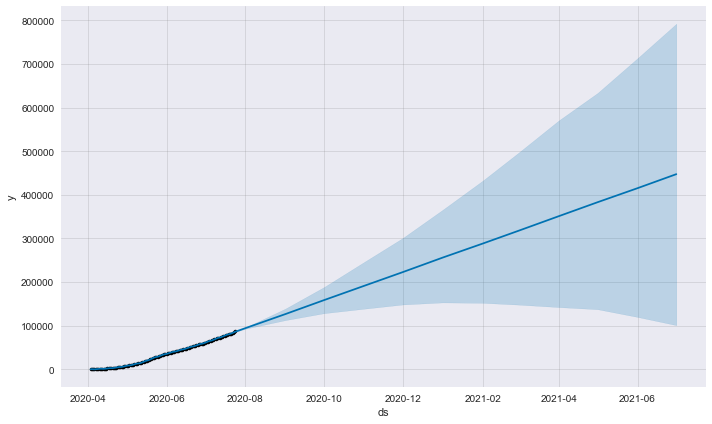

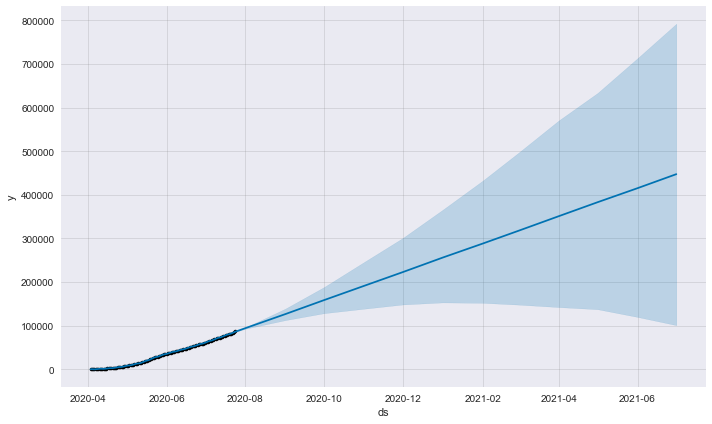

In [16]:
model.plot(forecast,
              uncertainty=True)

### Análise
Como podemos ver, num cenário simples onde não possuímos os dados de queda da curva ou do total da população (geral e percentual contaminado), não podemos dizer que a curva em algum momenento vai descer. No momento a previsão para os próximos 12 meses é só a subida do número de casos confirmados.

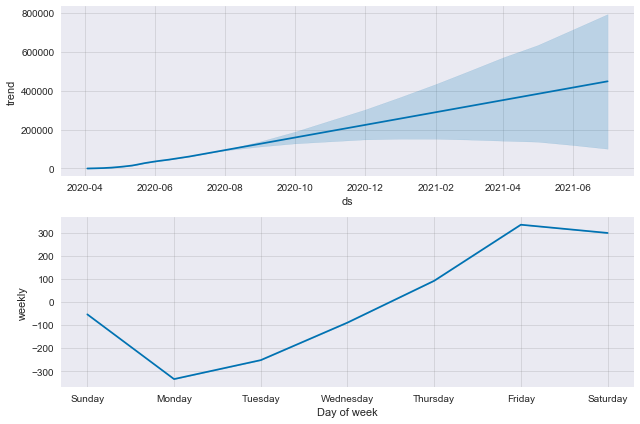

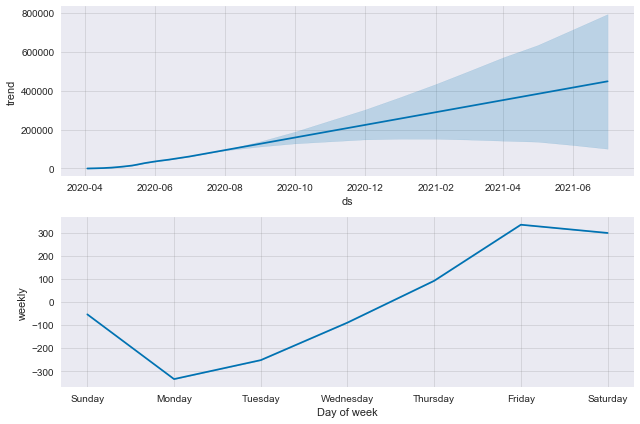

In [17]:
model.plot_components(forecast)

### Análise

Utilizando o total de casos confirmados é notório que o número de caso notificados chega a aumentar no meio da semana e ser menor na segunda e finais de semana pela subnotificação do número de casos como predito no cenário anterior.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


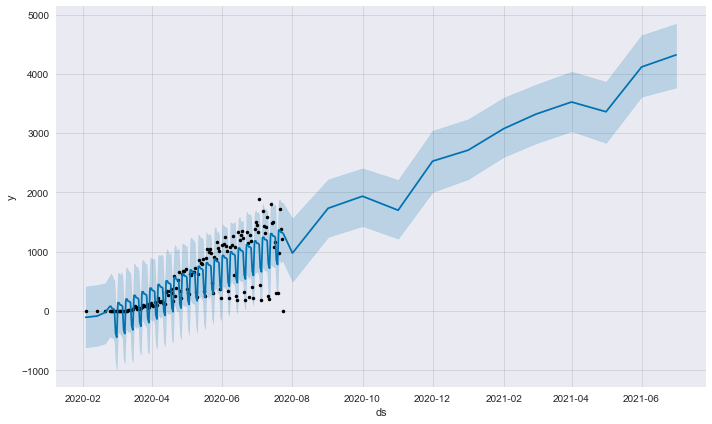

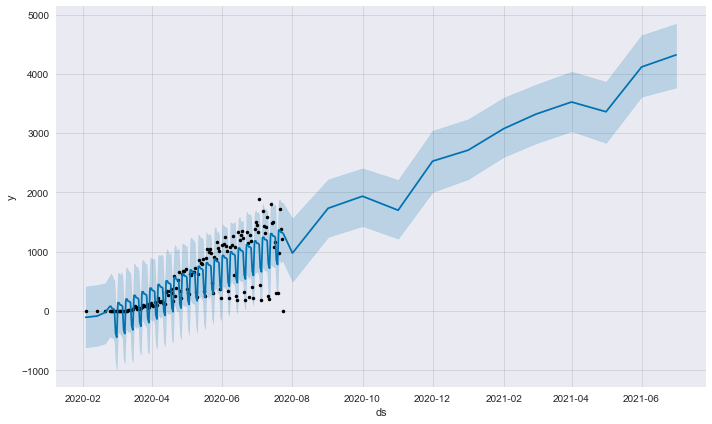

In [18]:
model = Prophet(interval_width=0.95)
model.fit(pd.DataFrame({'ds':lista_data, 'y':lista_homem}))
future_dates = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future_dates)
model.plot(forecast,
              uncertainty=True)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


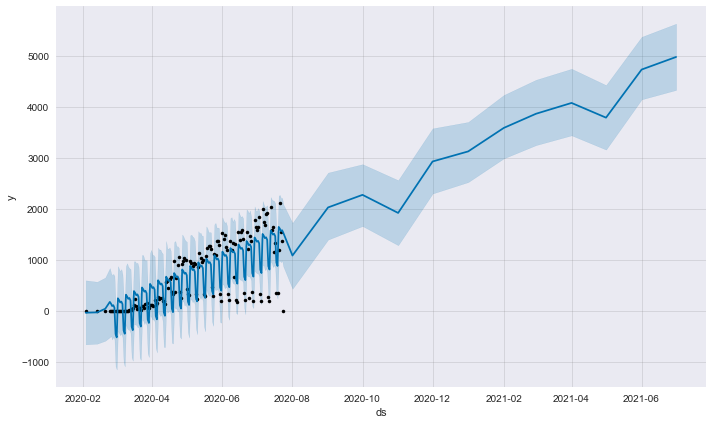

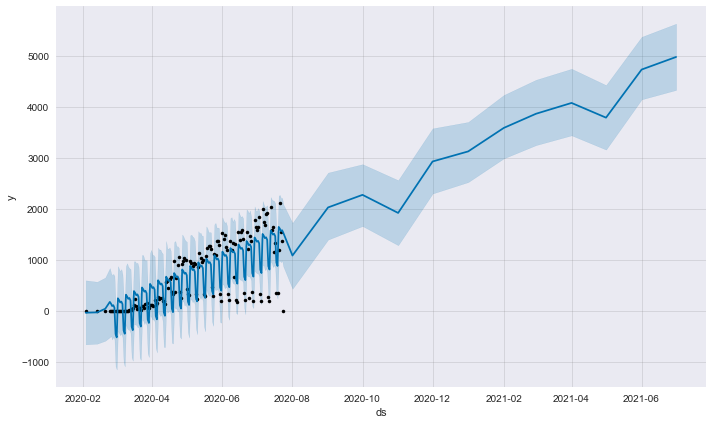

In [19]:
model = Prophet(interval_width=0.95)
model.fit(pd.DataFrame({'ds':lista_data, 'y':lista_mulher}))
future_dates = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future_dates)
model.plot(forecast,
              uncertainty=True)

### Análise

O mesmo pode comportamento encontrado nos casos totais pode ser observado para os casos isolados para o sexo feminio e masculino.

Várias outra análises e conexões podem ser feitas usando os mesmos moldes e outros modelos preditivos como Redes Neurais, modelos da conjunto ARIMA, regressões lineares e inclusive SVM's.